In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import os
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from regions import CircleSkyRegion
from gammapy.spectrum import (
    SpectrumDatasetOnOff,
    SpectrumDataset,
    SpectrumDatasetMaker,
)
from gammapy.modeling import Fit, Parameter
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SpectralModel,
    SkyModel,
    ExpCutoffPowerLawSpectralModel,
)
from gammapy.irf import load_cta_irfs
from gammapy.data import Observation
from gammapy.maps import MapAxis

In [3]:
livetime = 48 * u.h
pointing = SkyCoord(0, 0, unit="deg", frame="galactic")
offset = 0.5 * u.deg
# Reconstructed and true energy axis
energy_axis = MapAxis.from_edges(
    np.logspace(-1.5, 2.0, 10), unit="TeV", name="energy", interp="log"
)
energy_axis_true = MapAxis.from_edges(
    np.logspace(-1.5, 2.0, 31), unit="TeV", name="energy", interp="log"
)

on_region_radius = Angle("0.11 deg")
on_region = CircleSkyRegion(center=pointing, radius=on_region_radius)

In [4]:
# Define spectral model - a simple Power Law in this case
model_simu = ExpCutoffPowerLawSpectralModel(
    index=2.22,
    amplitude=1.289e-12 * u.Unit("cm-2 s-1 TeV-1"),
    reference=1 * u.TeV,
    lambda_=5 * u.Unit("TeV-1"),
    alpha = 1,
)
print(model_simu)
# we set the sky model used in the dataset
model = SkyModel(spectral_model=model_simu)

ExpCutoffPowerLawSpectralModel

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.289e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.000e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True


In [5]:
os.environ['CALDB'] = '/home/rishank/anaconda2/envs/cta/share/caldb/'
!echo $CALDB
!ls $CALDB

/home/rishank/anaconda2/envs/cta/share/caldb/
data


In [6]:
# Load the IRFs
# In this simulation, we use the CTA-1DC irfs shipped with gammapy.
irfs = load_cta_irfs(
    "$CALDB/data/cta/prod3b-v2/bcf/South_z20_50h/irf_file.fits"
)

In [7]:
obs = Observation.create(pointing=pointing, livetime=livetime, irfs=irfs)
print(obs)

Info for OBS_ID = 1
- Pointing pos: RA 266.40 deg / Dec -28.94 deg
- Livetime duration: 172800.0 s



In [8]:
# Make the SpectrumDataset
dataset_empty = SpectrumDataset.create(
    e_reco=energy_axis.edges, e_true=energy_axis_true.edges, region=on_region
)
maker = SpectrumDatasetMaker(selection=["aeff", "edisp", "background"])
dataset = maker.run(dataset_empty, obs)

In [9]:
# Set the model on the dataset, and fake
dataset.model = model
dataset.fake(random_state=42)
print(dataset)

SpectrumDataset

    Name                            : 1 

    Total counts                    : 20280 
    Total predicted counts          : nan
    Total background counts         : 20309.41

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 1.73e+05 s

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : cash
    Fit statistic value (-2 log(L)) : nan

    Number of parameters            : 0
    Number of free parameters       : 0




In [10]:
dataset_onoff = SpectrumDatasetOnOff(
    aeff=dataset.aeff,
    edisp=dataset.edisp,
    models=model,
    livetime=livetime,
    acceptance=1,
    acceptance_off=5,
)
dataset_onoff.fake(background_model=dataset.background)
print(dataset_onoff)

SpectrumDatasetOnOff

    Name                            :  

    Total counts                    : 26438 
    Total predicted counts          : 26514.13
    Total off counts                : 101654.00

    Total background counts         : 20330.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.58

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0



In [11]:

%%time

n_obs = 2000
datasets = []

for idx in range(n_obs):
    dataset_onoff.fake(random_state=idx, background_model=dataset.background)
    dataset_onoff.name = f"obs_{idx}"
    datasets.append(dataset_onoff.copy())

CPU times: user 11.7 s, sys: 50.1 ms, total: 11.8 s
Wall time: 11.9 s


In [12]:
print(*datasets, sep = "\n") 

SpectrumDatasetOnOff

    Name                            : obs_0 

    Total counts                    : 26536 
    Total predicted counts          : 26596.33
    Total off counts                : 102065.00

    Total background counts         : 20413.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.09

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1 

    Total counts                    : 26375 
    Total predicted counts          : 26517.73
    Total off counts                : 101672.00

    Total background counts         : 20

SpectrumDatasetOnOff

    Name                            : obs_11 

    Total counts                    : 26326 
    Total predicted counts          : 26503.53
    Total off counts                : 101601.00

    Total background counts         : 20320.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.22

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_12 

    Total counts                    : 26532 
    Total predicted counts          : 26545.33
    Total off counts                : 101810.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_24 

    Total counts                    : 26660 
    Total predicted counts          : 26584.33
    Total off counts                : 102005.00

    Total background counts         : 20401.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.85

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_25 

    Total counts                    : 26347 
    Total predicted counts          : 26462.13
    Total off counts                : 101394.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_35 

    Total counts                    : 26470 
    Total predicted counts          : 26573.13
    Total off counts                : 101949.00

    Total background counts         : 20389.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.22

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_36 

    Total counts                    : 26503 
    Total predicted counts          : 26425.13
    Total off counts                : 101209.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_47 

    Total counts                    : 26608 
    Total predicted counts          : 26612.53
    Total off counts                : 102146.00

    Total background counts         : 20429.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.77

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_48 

    Total counts                    : 26485 
    Total predicted counts          : 26521.13
    Total off counts                : 101689.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_61 

    Total counts                    : 26753 
    Total predicted counts          : 26619.33
    Total off counts                : 102180.00

    Total background counts         : 20436.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.83

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_62 

    Total counts                    : 26668 
    Total predicted counts          : 26505.53
    Total off counts                : 101611.00

    Total background counts         :

SpectrumDatasetOnOff

    Name                            : obs_77 

    Total counts                    : 26547 
    Total predicted counts          : 26441.73
    Total off counts                : 101292.00

    Total background counts         : 20258.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.23

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_78 

    Total counts                    : 26509 
    Total predicted counts          : 26354.13
    Total off counts                : 100854.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_91 

    Total counts                    : 26235 
    Total predicted counts          : 26523.13
    Total off counts                : 101699.00

    Total background counts         : 20339.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.42

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_92 

    Total counts                    : 26753 
    Total predicted counts          : 26525.93
    Total off counts                : 101713.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_107 

    Total counts                    : 26327 
    Total predicted counts          : 26556.33
    Total off counts                : 101865.00

    Total background counts         : 20373.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.03

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_108 

    Total counts                    : 26523 
    Total predicted counts          : 26569.73
    Total off counts                : 101932.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_129 

    Total counts                    : 26729 
    Total predicted counts          : 26504.53
    Total off counts                : 101606.00

    Total background counts         : 20321.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.24

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_130 

    Total counts                    : 26561 
    Total predicted counts          : 26576.13
    Total off counts                : 101964.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_147 

    Total counts                    : 26419 
    Total predicted counts          : 26306.33
    Total off counts                : 100615.00

    Total background counts         : 20123.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.87

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_148 

    Total counts                    : 26384 
    Total predicted counts          : 26561.73
    Total off counts                : 101892.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_163 

    Total counts                    : 26746 
    Total predicted counts          : 26580.53
    Total off counts                : 101986.00

    Total background counts         : 20397.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.28

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_164 

    Total counts                    : 26795 
    Total predicted counts          : 26463.53
    Total off counts                : 101401.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_180 

    Total counts                    : 26481 
    Total predicted counts          : 26524.73
    Total off counts                : 101707.00

    Total background counts         : 20341.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.89

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_181 

    Total counts                    : 26398 
    Total predicted counts          : 26539.53
    Total off counts                : 101781.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_195 

    Total counts                    : 26447 
    Total predicted counts          : 26500.53
    Total off counts                : 101586.00

    Total background counts         : 20317.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 1.43

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_196 

    Total counts                    : 26440 
    Total predicted counts          : 26418.93
    Total off counts                : 101178.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_216 

    Total counts                    : 26509 
    Total predicted counts          : 26422.13
    Total off counts                : 101194.00

    Total background counts         : 20238.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 1.67

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_217 

    Total counts                    : 26358 
    Total predicted counts          : 26497.73
    Total off counts                : 101572.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_235 

    Total counts                    : 26483 
    Total predicted counts          : 26490.53
    Total off counts                : 101536.00

    Total background counts         : 20307.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.66

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_236 

    Total counts                    : 26183 
    Total predicted counts          : 26505.73
    Total off counts                : 101612.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_249 

    Total counts                    : 26614 
    Total predicted counts          : 26431.13
    Total off counts                : 101239.00

    Total background counts         : 20247.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.97

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_250 

    Total counts                    : 26800 
    Total predicted counts          : 26512.13
    Total off counts                : 101644.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_266 

    Total counts                    : 26499 
    Total predicted counts          : 26574.33
    Total off counts                : 101955.00

    Total background counts         : 20391.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.50

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_267 

    Total counts                    : 26503 
    Total predicted counts          : 26480.33
    Total off counts                : 101485.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_280 

    Total counts                    : 26610 
    Total predicted counts          : 26559.13
    Total off counts                : 101879.00

    Total background counts         : 20375.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.94

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_281 

    Total counts                    : 26352 
    Total predicted counts          : 26513.73
    Total off counts                : 101652.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_295 

    Total counts                    : 26499 
    Total predicted counts          : 26515.33
    Total off counts                : 101660.00

    Total background counts         : 20332.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.47

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_296 

    Total counts                    : 26735 
    Total predicted counts          : 26493.13
    Total off counts                : 101549.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_310 

    Total counts                    : 26596 
    Total predicted counts          : 26513.93
    Total off counts                : 101653.00

    Total background counts         : 20330.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.62

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_311 

    Total counts                    : 26575 
    Total predicted counts          : 26516.53
    Total off counts                : 101666.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_326 

    Total counts                    : 26656 
    Total predicted counts          : 26462.93
    Total off counts                : 101398.00

    Total background counts         : 20279.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.08

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_327 

    Total counts                    : 26309 
    Total predicted counts          : 26560.93
    Total off counts                : 101888.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_344 

    Total counts                    : 26331 
    Total predicted counts          : 26448.53
    Total off counts                : 101326.00

    Total background counts         : 20265.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.59

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_345 

    Total counts                    : 26543 
    Total predicted counts          : 26432.33
    Total off counts                : 101245.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_362 

    Total counts                    : 26293 
    Total predicted counts          : 26576.13
    Total off counts                : 101964.00

    Total background counts         : 20392.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.17

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_363 

    Total counts                    : 26232 
    Total predicted counts          : 26479.13
    Total off counts                : 101479.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_379 

    Total counts                    : 26538 
    Total predicted counts          : 26501.73
    Total off counts                : 101592.00

    Total background counts         : 20318.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.41

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_380 

    Total counts                    : 26562 
    Total predicted counts          : 26601.93
    Total off counts                : 102093.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_396 

    Total counts                    : 26550 
    Total predicted counts          : 26435.13
    Total off counts                : 101259.00

    Total background counts         : 20251.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.99

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_397 

    Total counts                    : 26219 
    Total predicted counts          : 26482.53
    Total off counts                : 101496.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_412 

    Total counts                    : 26347 
    Total predicted counts          : 26438.13
    Total off counts                : 101274.00

    Total background counts         : 20254.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.75

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_413 

    Total counts                    : 26510 
    Total predicted counts          : 26522.93
    Total off counts                : 101698.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_424 

    Total counts                    : 26440 
    Total predicted counts          : 26510.93
    Total off counts                : 101638.00

    Total background counts         : 20327.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.45

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_425 

    Total counts                    : 26581 
    Total predicted counts          : 26475.93
    Total off counts                : 101463.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_436 

    Total counts                    : 26367 
    Total predicted counts          : 26458.73
    Total off counts                : 101377.00

    Total background counts         : 20275.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.00

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_437 

    Total counts                    : 26369 
    Total predicted counts          : 26521.93
    Total off counts                : 101693.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_450 

    Total counts                    : 26528 
    Total predicted counts          : 26483.13
    Total off counts                : 101499.00

    Total background counts         : 20299.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.52

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_451 

    Total counts                    : 26465 
    Total predicted counts          : 26523.53
    Total off counts                : 101701.00

    Total background counts         


SpectrumDatasetOnOff

    Name                            : obs_468 

    Total counts                    : 26586 
    Total predicted counts          : 26446.73
    Total off counts                : 101317.00

    Total background counts         : 20263.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.79

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_469 

    Total counts                    : 26451 
    Total predicted counts          : 26502.93
    Total off counts                : 101598.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_485 

    Total counts                    : 26863 
    Total predicted counts          : 26594.93
    Total off counts                : 102058.00

    Total background counts         : 20411.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.53

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_486 

    Total counts                    : 26485 
    Total predicted counts          : 26508.53
    Total off counts                : 101626.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_501 

    Total counts                    : 26207 
    Total predicted counts          : 26509.53
    Total off counts                : 101631.00

    Total background counts         : 20326.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 14.34

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_502 

    Total counts                    : 26559 
    Total predicted counts          : 26481.73
    Total off counts                : 101492.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_519 

    Total counts                    : 26505 
    Total predicted counts          : 26486.33
    Total off counts                : 101515.00

    Total background counts         : 20303.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.32

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_520 

    Total counts                    : 26399 
    Total predicted counts          : 26500.33
    Total off counts                : 101585.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_531 

    Total counts                    : 26625 
    Total predicted counts          : 26404.13
    Total off counts                : 101104.00

    Total background counts         : 20220.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.87

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_532 

    Total counts                    : 26552 
    Total predicted counts          : 26470.33
    Total off counts                : 101435.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_551 

    Total counts                    : 26627 
    Total predicted counts          : 26493.73
    Total off counts                : 101552.00

    Total background counts         : 20310.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.64

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_552 

    Total counts                    : 26436 
    Total predicted counts          : 26540.13
    Total off counts                : 101784.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_570 

    Total counts                    : 26548 
    Total predicted counts          : 26534.33
    Total off counts                : 101755.00

    Total background counts         : 20351.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.44

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_571 

    Total counts                    : 26503 
    Total predicted counts          : 26606.33
    Total off counts                : 102115.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_588 

    Total counts                    : 26351 
    Total predicted counts          : 26483.13
    Total off counts                : 101499.00

    Total background counts         : 20299.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.87

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_589 

    Total counts                    : 26579 
    Total predicted counts          : 26498.53
    Total off counts                : 101576.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_606 

    Total counts                    : 26375 
    Total predicted counts          : 26490.53
    Total off counts                : 101536.00

    Total background counts         : 20307.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.45

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_607 

    Total counts                    : 26540 
    Total predicted counts          : 26444.13
    Total off counts                : 101304.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_625 

    Total counts                    : 26008 
    Total predicted counts          : 26547.73
    Total off counts                : 101822.00

    Total background counts         : 20364.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 14.92

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_626 

    Total counts                    : 26398 
    Total predicted counts          : 26495.33
    Total off counts                : 101560.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_645 

    Total counts                    : 26655 
    Total predicted counts          : 26523.13
    Total off counts                : 101699.00

    Total background counts         : 20339.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.91

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_646 

    Total counts                    : 26311 
    Total predicted counts          : 26467.93
    Total off counts                : 101423.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_663 

    Total counts                    : 26454 
    Total predicted counts          : 26552.73
    Total off counts                : 101847.00

    Total background counts         : 20369.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 1.20

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_664 

    Total counts                    : 26338 
    Total predicted counts          : 26431.73
    Total off counts                : 101242.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_682 

    Total counts                    : 26417 
    Total predicted counts          : 26526.33
    Total off counts                : 101715.00

    Total background counts         : 20343.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 14.37

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_683 

    Total counts                    : 26381 
    Total predicted counts          : 26456.33
    Total off counts                : 101365.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_701 

    Total counts                    : 26767 
    Total predicted counts          : 26411.93
    Total off counts                : 101143.00

    Total background counts         : 20228.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 17.05

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_702 

    Total counts                    : 26381 
    Total predicted counts          : 26405.53
    Total off counts                : 101111.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_721 

    Total counts                    : 26242 
    Total predicted counts          : 26422.13
    Total off counts                : 101194.00

    Total background counts         : 20238.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.26

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_722 

    Total counts                    : 26308 
    Total predicted counts          : 26522.53
    Total off counts                : 101696.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_734 

    Total counts                    : 26706 
    Total predicted counts          : 26507.53
    Total off counts                : 101621.00

    Total background counts         : 20324.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 15.22

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_735 

    Total counts                    : 26515 
    Total predicted counts          : 26485.53
    Total off counts                : 101511.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_748 

    Total counts                    : 26910 
    Total predicted counts          : 26503.53
    Total off counts                : 101601.00

    Total background counts         : 20320.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 14.29

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_749 

    Total counts                    : 26582 
    Total predicted counts          : 26490.93
    Total off counts                : 101538.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_771 

    Total counts                    : 26587 
    Total predicted counts          : 26532.53
    Total off counts                : 101746.00

    Total background counts         : 20349.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.57

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_772 

    Total counts                    : 26435 
    Total predicted counts          : 26492.33
    Total off counts                : 101545.00

    Total background counts         


SpectrumDatasetOnOff

    Name                            : obs_786 

    Total counts                    : 26725 
    Total predicted counts          : 26461.13
    Total off counts                : 101389.00

    Total background counts         : 20277.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.19

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_787 

    Total counts                    : 26642 
    Total predicted counts          : 26502.73
    Total off counts                : 101597.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_805 

    Total counts                    : 26233 
    Total predicted counts          : 26491.33
    Total off counts                : 101540.00

    Total background counts         : 20308.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.56

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_806 

    Total counts                    : 26459 
    Total predicted counts          : 26503.93
    Total off counts                : 101603.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_816 

    Total counts                    : 26387 
    Total predicted counts          : 26539.93
    Total off counts                : 101783.00

    Total background counts         : 20356.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.25

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_817 

    Total counts                    : 26523 
    Total predicted counts          : 26484.13
    Total off counts                : 101504.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_827 

    Total counts                    : 26506 
    Total predicted counts          : 26477.13
    Total off counts                : 101469.00

    Total background counts         : 20293.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.56

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_828 

    Total counts                    : 26264 
    Total predicted counts          : 26462.33
    Total off counts                : 101395.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_839 

    Total counts                    : 26308 
    Total predicted counts          : 26475.13
    Total off counts                : 101459.00

    Total background counts         : 20291.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 16.40

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_840 

    Total counts                    : 26434 
    Total predicted counts          : 26549.33
    Total off counts                : 101830.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_850 

    Total counts                    : 26282 
    Total predicted counts          : 26498.73
    Total off counts                : 101577.00

    Total background counts         : 20315.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.00

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_851 

    Total counts                    : 26320 
    Total predicted counts          : 26454.73
    Total off counts                : 101357.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_870 

    Total counts                    : 26274 
    Total predicted counts          : 26571.13
    Total off counts                : 101939.00

    Total background counts         : 20387.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.80

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_871 

    Total counts                    : 26569 
    Total predicted counts          : 26446.93
    Total off counts                : 101318.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_882 

    Total counts                    : 26534 
    Total predicted counts          : 26516.73
    Total off counts                : 101667.00

    Total background counts         : 20333.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.15

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_883 

    Total counts                    : 26588 
    Total predicted counts          : 26413.53
    Total off counts                : 101151.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_894 

    Total counts                    : 26641 
    Total predicted counts          : 26504.73
    Total off counts                : 101607.00

    Total background counts         : 20321.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.87

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_895 

    Total counts                    : 26706 
    Total predicted counts          : 26493.93
    Total off counts                : 101553.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_916 

    Total counts                    : 26651 
    Total predicted counts          : 26570.53
    Total off counts                : 101936.00

    Total background counts         : 20387.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.14

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_917 

    Total counts                    : 26657 
    Total predicted counts          : 26411.33
    Total off counts                : 101140.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_937 

    Total counts                    : 26682 
    Total predicted counts          : 26626.53
    Total off counts                : 102216.00

    Total background counts         : 20443.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 15.74

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_938 

    Total counts                    : 26507 
    Total predicted counts          : 26444.33
    Total off counts                : 101305.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_965 

    Total counts                    : 26717 
    Total predicted counts          : 26525.73
    Total off counts                : 101712.00

    Total background counts         : 20342.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.64

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_966 

    Total counts                    : 26529 
    Total predicted counts          : 26487.13
    Total off counts                : 101519.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_979 

    Total counts                    : 26679 
    Total predicted counts          : 26521.33
    Total off counts                : 101690.00

    Total background counts         : 20338.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.49

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_980 

    Total counts                    : 26675 
    Total predicted counts          : 26540.93
    Total off counts                : 101788.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_996 

    Total counts                    : 26670 
    Total predicted counts          : 26542.33
    Total off counts                : 101795.00

    Total background counts         : 20359.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.65

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_997 

    Total counts                    : 26310 
    Total predicted counts          : 26444.33
    Total off counts                : 101305.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_1010 

    Total counts                    : 26448 
    Total predicted counts          : 26471.93
    Total off counts                : 101443.00

    Total background counts         : 20288.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 1.58

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1011 

    Total counts                    : 26581 
    Total predicted counts          : 26436.13
    Total off counts                : 101264.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1026 

    Total counts                    : 26687 
    Total predicted counts          : 26476.53
    Total off counts                : 101466.00

    Total background counts         : 20293.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.69

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1027 

    Total counts                    : 26696 
    Total predicted counts          : 26625.13
    Total off counts                : 102209.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1039 

    Total counts                    : 26576 
    Total predicted counts          : 26439.53
    Total off counts                : 101281.00

    Total background counts         : 20256.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.02

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1040 

    Total counts                    : 26813 
    Total predicted counts          : 26598.93
    Total off counts                : 102078.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1057 

    Total counts                    : 26403 
    Total predicted counts          : 26609.33
    Total off counts                : 102130.00

    Total background counts         : 20426.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 26.40

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1058 

    Total counts                    : 26418 
    Total predicted counts          : 26416.13
    Total off counts                : 101164.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1074 

    Total counts                    : 26516 
    Total predicted counts          : 26556.13
    Total off counts                : 101864.00

    Total background counts         : 20372.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.84

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1075 

    Total counts                    : 26454 
    Total predicted counts          : 26415.33
    Total off counts                : 101160.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1085 

    Total counts                    : 26450 
    Total predicted counts          : 26457.53
    Total off counts                : 101371.00

    Total background counts         : 20274.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.26

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1086 

    Total counts                    : 26877 
    Total predicted counts          : 26507.73
    Total off counts                : 101622.00

    Total background counts      


SpectrumDatasetOnOff

    Name                            : obs_1100 

    Total counts                    : 26559 
    Total predicted counts          : 26466.53
    Total off counts                : 101416.00

    Total background counts         : 20283.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.79

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1101 

    Total counts                    : 26551 
    Total predicted counts          : 26489.93
    Total off counts                : 101533.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1114 

    Total counts                    : 26466 
    Total predicted counts          : 26511.33
    Total off counts                : 101640.00

    Total background counts         : 20328.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.77

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1115 

    Total counts                    : 26510 
    Total predicted counts          : 26577.93
    Total off counts                : 101973.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1127 

    Total counts                    : 26574 
    Total predicted counts          : 26439.73
    Total off counts                : 101282.00

    Total background counts         : 20256.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.26

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1128 

    Total counts                    : 26545 
    Total predicted counts          : 26610.93
    Total off counts                : 102138.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1140 

    Total counts                    : 26413 
    Total predicted counts          : 26440.93
    Total off counts                : 101288.00

    Total background counts         : 20257.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.21

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1141 

    Total counts                    : 26561 
    Total predicted counts          : 26452.13
    Total off counts                : 101344.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_1156 

    Total counts                    : 26511 
    Total predicted counts          : 26432.53
    Total off counts                : 101246.00

    Total background counts         : 20249.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.38

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1157 

    Total counts                    : 26722 
    Total predicted counts          : 26521.33
    Total off counts                : 101690.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1171 

    Total counts                    : 26407 
    Total predicted counts          : 26376.13
    Total off counts                : 100964.00

    Total background counts         : 20192.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.53

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1172 

    Total counts                    : 26641 
    Total predicted counts          : 26479.93
    Total off counts                : 101483.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1183 

    Total counts                    : 26517 
    Total predicted counts          : 26526.33
    Total off counts                : 101715.00

    Total background counts         : 20343.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.37

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1184 

    Total counts                    : 26683 
    Total predicted counts          : 26453.53
    Total off counts                : 101351.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1194 

    Total counts                    : 26557 
    Total predicted counts          : 26588.13
    Total off counts                : 102024.00

    Total background counts         : 20404.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.35

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1195 

    Total counts                    : 26634 
    Total predicted counts          : 26471.33
    Total off counts                : 101440.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1208 

    Total counts                    : 26545 
    Total predicted counts          : 26507.93
    Total off counts                : 101623.00

    Total background counts         : 20324.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.81

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1209 

    Total counts                    : 26237 
    Total predicted counts          : 26477.73
    Total off counts                : 101472.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1223 

    Total counts                    : 26511 
    Total predicted counts          : 26543.73
    Total off counts                : 101802.00

    Total background counts         : 20360.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.84

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1224 

    Total counts                    : 26267 
    Total predicted counts          : 26521.73
    Total off counts                : 101692.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1235 

    Total counts                    : 26437 
    Total predicted counts          : 26559.13
    Total off counts                : 101879.00

    Total background counts         : 20375.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.41

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1236 

    Total counts                    : 26451 
    Total predicted counts          : 26527.93
    Total off counts                : 101723.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1253 

    Total counts                    : 26426 
    Total predicted counts          : 26519.73
    Total off counts                : 101682.00

    Total background counts         : 20336.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.28

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1254 

    Total counts                    : 26510 
    Total predicted counts          : 26586.73
    Total off counts                : 102017.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1268 

    Total counts                    : 26291 
    Total predicted counts          : 26545.73
    Total off counts                : 101812.00

    Total background counts         : 20362.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.88

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1269 

    Total counts                    : 26442 
    Total predicted counts          : 26491.93
    Total off counts                : 101543.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1288 

    Total counts                    : 26558 
    Total predicted counts          : 26565.33
    Total off counts                : 101910.00

    Total background counts         : 20382.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.19

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1289 

    Total counts                    : 26546 
    Total predicted counts          : 26594.73
    Total off counts                : 102057.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1304 

    Total counts                    : 26665 
    Total predicted counts          : 26433.73
    Total off counts                : 101252.00

    Total background counts         : 20250.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.11

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1305 

    Total counts                    : 26459 
    Total predicted counts          : 26455.93
    Total off counts                : 101363.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1318 

    Total counts                    : 26370 
    Total predicted counts          : 26466.13
    Total off counts                : 101414.00

    Total background counts         : 20282.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.48

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1319 

    Total counts                    : 26291 
    Total predicted counts          : 26472.53
    Total off counts                : 101446.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1331 

    Total counts                    : 26836 
    Total predicted counts          : 26504.13
    Total off counts                : 101604.00

    Total background counts         : 20320.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.05

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1332 

    Total counts                    : 26343 
    Total predicted counts          : 26593.53
    Total off counts                : 102051.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1347 

    Total counts                    : 26283 
    Total predicted counts          : 26515.13
    Total off counts                : 101659.00

    Total background counts         : 20331.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.01

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1348 

    Total counts                    : 26486 
    Total predicted counts          : 26519.53
    Total off counts                : 101681.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1360 

    Total counts                    : 26351 
    Total predicted counts          : 26469.53
    Total off counts                : 101431.00

    Total background counts         : 20286.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.54

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1361 

    Total counts                    : 26623 
    Total predicted counts          : 26463.33
    Total off counts                : 101400.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1378 

    Total counts                    : 26386 
    Total predicted counts          : 26517.33
    Total off counts                : 101670.00

    Total background counts         : 20334.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.36

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1379 

    Total counts                    : 26496 
    Total predicted counts          : 26505.53
    Total off counts                : 101611.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1397 

    Total counts                    : 26624 
    Total predicted counts          : 26550.33
    Total off counts                : 101835.00

    Total background counts         : 20367.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.62

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1398 

    Total counts                    : 26746 
    Total predicted counts          : 26484.53
    Total off counts                : 101506.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1414 

    Total counts                    : 26133 
    Total predicted counts          : 26457.73
    Total off counts                : 101372.00

    Total background counts         : 20274.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.94

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1415 

    Total counts                    : 26683 
    Total predicted counts          : 26611.53
    Total off counts                : 102141.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1425 

    Total counts                    : 26637 
    Total predicted counts          : 26514.53
    Total off counts                : 101656.00

    Total background counts         : 20331.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.53

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1426 

    Total counts                    : 26517 
    Total predicted counts          : 26494.53
    Total off counts                : 101556.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1437 

    Total counts                    : 26429 
    Total predicted counts          : 26551.93
    Total off counts                : 101843.00

    Total background counts         : 20368.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.86

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1438 

    Total counts                    : 26522 
    Total predicted counts          : 26583.33
    Total off counts                : 102000.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1451 

    Total counts                    : 26432 
    Total predicted counts          : 26410.93
    Total off counts                : 101138.00

    Total background counts         : 20227.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.28

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1452 

    Total counts                    : 26289 
    Total predicted counts          : 26444.93
    Total off counts                : 101308.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1465 

    Total counts                    : 26174 
    Total predicted counts          : 26456.33
    Total off counts                : 101365.00

    Total background counts         : 20273.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 20.57

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1466 

    Total counts                    : 26431 
    Total predicted counts          : 26426.33
    Total off counts                : 101215.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1482 

    Total counts                    : 26649 
    Total predicted counts          : 26490.93
    Total off counts                : 101538.00

    Total background counts         : 20307.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.99

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1483 

    Total counts                    : 26707 
    Total predicted counts          : 26540.33
    Total off counts                : 101785.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1498 

    Total counts                    : 26643 
    Total predicted counts          : 26330.13
    Total off counts                : 100734.00

    Total background counts         : 20146.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.72

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1499 

    Total counts                    : 26308 
    Total predicted counts          : 26546.13
    Total off counts                : 101814.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1512 

    Total counts                    : 26479 
    Total predicted counts          : 26536.13
    Total off counts                : 101764.00

    Total background counts         : 20352.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.08

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1513 

    Total counts                    : 26104 
    Total predicted counts          : 26496.53
    Total off counts                : 101566.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1525 

    Total counts                    : 26440 
    Total predicted counts          : 26446.13
    Total off counts                : 101314.00

    Total background counts         : 20262.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.03

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1526 

    Total counts                    : 26524 
    Total predicted counts          : 26457.33
    Total off counts                : 101370.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_1540 

    Total counts                    : 26633 
    Total predicted counts          : 26539.53
    Total off counts                : 101781.00

    Total background counts         : 20356.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.96

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1541 

    Total counts                    : 26447 
    Total predicted counts          : 26401.53
    Total off counts                : 101091.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1560 

    Total counts                    : 26477 
    Total predicted counts          : 26579.73
    Total off counts                : 101982.00

    Total background counts         : 20396.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.51

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1561 

    Total counts                    : 26923 
    Total predicted counts          : 26526.13
    Total off counts                : 101714.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1571 

    Total counts                    : 26525 
    Total predicted counts          : 26529.53
    Total off counts                : 101731.00

    Total background counts         : 20346.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.05

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1572 

    Total counts                    : 26619 
    Total predicted counts          : 26447.33
    Total off counts                : 101320.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1587 

    Total counts                    : 26530 
    Total predicted counts          : 26635.33
    Total off counts                : 102260.00

    Total background counts         : 20452.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.73

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1588 

    Total counts                    : 26426 
    Total predicted counts          : 26469.93
    Total off counts                : 101433.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1599 

    Total counts                    : 26459 
    Total predicted counts          : 26482.53
    Total off counts                : 101496.00

    Total background counts         : 20299.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 0.64

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1600 

    Total counts                    : 26591 
    Total predicted counts          : 26460.53
    Total off counts                : 101386.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1611 

    Total counts                    : 26511 
    Total predicted counts          : 26583.93
    Total off counts                : 102003.00

    Total background counts         : 20400.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.49

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1612 

    Total counts                    : 26504 
    Total predicted counts          : 26502.73
    Total off counts                : 101597.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1633 

    Total counts                    : 26222 
    Total predicted counts          : 26467.53
    Total off counts                : 101421.00

    Total background counts         : 20284.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.61

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1634 

    Total counts                    : 26549 
    Total predicted counts          : 26492.33
    Total off counts                : 101545.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1651 

    Total counts                    : 26268 
    Total predicted counts          : 26364.93
    Total off counts                : 100908.00

    Total background counts         : 20181.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.42

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1652 

    Total counts                    : 26338 
    Total predicted counts          : 26444.73
    Total off counts                : 101307.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1664 

    Total counts                    : 26523 
    Total predicted counts          : 26444.33
    Total off counts                : 101305.00

    Total background counts         : 20261.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.66

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1665 

    Total counts                    : 26489 
    Total predicted counts          : 26517.33
    Total off counts                : 101670.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1677 

    Total counts                    : 26514 
    Total predicted counts          : 26492.33
    Total off counts                : 101545.00

    Total background counts         : 20309.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.42

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1678 

    Total counts                    : 26882 
    Total predicted counts          : 26527.13
    Total off counts                : 101719.00

    Total background counts      


SpectrumDatasetOnOff

    Name                            : obs_1688 

    Total counts                    : 26304 
    Total predicted counts          : 26510.33
    Total off counts                : 101635.00

    Total background counts         : 20327.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 14.13

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1689 

    Total counts                    : 26629 
    Total predicted counts          : 26393.93
    Total off counts                : 101053.00

    Total background counts     

SpectrumDatasetOnOff

    Name                            : obs_1710 

    Total counts                    : 26679 
    Total predicted counts          : 26408.53
    Total off counts                : 101126.00

    Total background counts         : 20225.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.47

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1711 

    Total counts                    : 26313 
    Total predicted counts          : 26513.33
    Total off counts                : 101650.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1721 

    Total counts                    : 26327 
    Total predicted counts          : 26493.53
    Total off counts                : 101551.00

    Total background counts         : 20310.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.08

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1722 

    Total counts                    : 26601 
    Total predicted counts          : 26533.73
    Total off counts                : 101752.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1733 

    Total counts                    : 26294 
    Total predicted counts          : 26626.13
    Total off counts                : 102214.00

    Total background counts         : 20442.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.67

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1734 

    Total counts                    : 26615 
    Total predicted counts          : 26543.33
    Total off counts                : 101800.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1746 

    Total counts                    : 26684 
    Total predicted counts          : 26572.33
    Total off counts                : 101945.00

    Total background counts         : 20389.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.63

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1747 

    Total counts                    : 26649 
    Total predicted counts          : 26554.93
    Total off counts                : 101858.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1762 

    Total counts                    : 26357 
    Total predicted counts          : 26499.53
    Total off counts                : 101581.00

    Total background counts         : 20316.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.32

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1763 

    Total counts                    : 26391 
    Total predicted counts          : 26511.33
    Total off counts                : 101640.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1778 

    Total counts                    : 26548 
    Total predicted counts          : 26411.53
    Total off counts                : 101141.00

    Total background counts         : 20228.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.31

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1779 

    Total counts                    : 26543 
    Total predicted counts          : 26410.33
    Total off counts                : 101135.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1797 

    Total counts                    : 26376 
    Total predicted counts          : 26458.93
    Total off counts                : 101378.00

    Total background counts         : 20275.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.74

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1798 

    Total counts                    : 26497 
    Total predicted counts          : 26489.93
    Total off counts                : 101533.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1813 

    Total counts                    : 26325 
    Total predicted counts          : 26473.73
    Total off counts                : 101452.00

    Total background counts         : 20290.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.46

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1814 

    Total counts                    : 26749 
    Total predicted counts          : 26481.53
    Total off counts                : 101491.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1824 

    Total counts                    : 26391 
    Total predicted counts          : 26477.93
    Total off counts                : 101473.00

    Total background counts         : 20294.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 1.22

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1825 

    Total counts                    : 26437 
    Total predicted counts          : 26682.93
    Total off counts                : 102498.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1836 

    Total counts                    : 26458 
    Total predicted counts          : 26531.53
    Total off counts                : 101741.00

    Total background counts         : 20348.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.45

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1837 

    Total counts                    : 26457 
    Total predicted counts          : 26522.53
    Total off counts                : 101696.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1848 

    Total counts                    : 26418 
    Total predicted counts          : 26453.93
    Total off counts                : 101353.00

    Total background counts         : 20270.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.06

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1849 

    Total counts                    : 26425 
    Total predicted counts          : 26550.93
    Total off counts                : 101838.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1859 

    Total counts                    : 26710 
    Total predicted counts          : 26575.13
    Total off counts                : 101959.00

    Total background counts         : 20391.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.36

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1860 

    Total counts                    : 26270 
    Total predicted counts          : 26445.93
    Total off counts                : 101313.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1877 

    Total counts                    : 26212 
    Total predicted counts          : 26512.93
    Total off counts                : 101648.00

    Total background counts         : 20329.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.41

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1878 

    Total counts                    : 26561 
    Total predicted counts          : 26412.53
    Total off counts                : 101146.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1888 

    Total counts                    : 26402 
    Total predicted counts          : 26413.93
    Total off counts                : 101153.00

    Total background counts         : 20230.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.13

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1889 

    Total counts                    : 26456 
    Total predicted counts          : 26402.93
    Total off counts                : 101098.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1907 

    Total counts                    : 26516 
    Total predicted counts          : 26418.53
    Total off counts                : 101176.00

    Total background counts         : 20235.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 1.27

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1908 

    Total counts                    : 26617 
    Total predicted counts          : 26447.53
    Total off counts                : 101321.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1921 

    Total counts                    : 26474 
    Total predicted counts          : 26437.13
    Total off counts                : 101269.00

    Total background counts         : 20253.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.28

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1922 

    Total counts                    : 26396 
    Total predicted counts          : 26457.13
    Total off counts                : 101369.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1938 

    Total counts                    : 26092 
    Total predicted counts          : 26595.53
    Total off counts                : 102061.00

    Total background counts         : 20412.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 16.48

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1939 

    Total counts                    : 26502 
    Total predicted counts          : 26597.33
    Total off counts                : 102070.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1956 

    Total counts                    : 26535 
    Total predicted counts          : 26522.93
    Total off counts                : 101698.00

    Total background counts         : 20339.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.72

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1957 

    Total counts                    : 26375 
    Total predicted counts          : 26521.73
    Total off counts                : 101692.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1972 

    Total counts                    : 26186 
    Total predicted counts          : 26561.33
    Total off counts                : 101890.00

    Total background counts         : 20378.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 16.37

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1973 

    Total counts                    : 26449 
    Total predicted counts          : 26429.13
    Total off counts                : 101229.00

    Total background counts      


SpectrumDatasetOnOff

    Name                            : obs_1990 

    Total counts                    : 26520 
    Total predicted counts          : 26578.53
    Total off counts                : 101976.00

    Total background counts         : 20395.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.91

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1991 

    Total counts                    : 26442 
    Total predicted counts          : 26498.93
    Total off counts                : 101578.00

    Total background counts     

Text(0, 0.5, 'No. of observations')

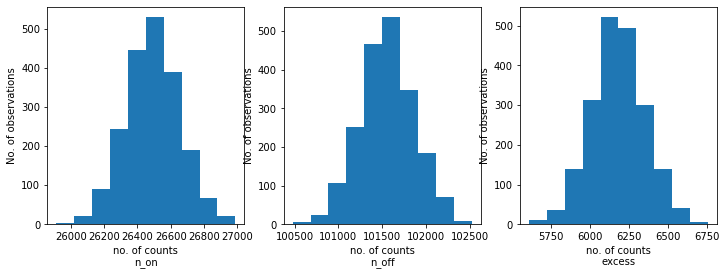

In [13]:

n_on = [dataset.counts.data.sum() for dataset in datasets]
n_off = [dataset.counts_off.data.sum() for dataset in datasets]
excess = [dataset.excess.data.sum() for dataset in datasets]

fix, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].hist(n_on)
axes[0].set_xlabel("no. of counts\nn_on")
axes[0].set_ylabel("No. of observations")
axes[1].hist(n_off)
axes[1].set_xlabel("no. of counts\nn_off")
axes[1].set_ylabel("No. of observations")
axes[2].hist(excess)
axes[2].set_xlabel("no. of counts\nexcess");
axes[2].set_ylabel("No. of observations")

In [14]:

%%time
results = []
for dataset in datasets:
    dataset.models = model.copy()
    fit = Fit([dataset])
    result = fit.optimize()
    results.append(
        {
            "index": result.parameters["index"].value,
            "amplitude": result.parameters["amplitude"].value,
            "lambda_": result.parameters["lambda_"].value,
        }
    )

CPU times: user 16min 55s, sys: 4.59 s, total: 17min
Wall time: 22min 38s


In [15]:
results

[{'index': 2.169752569491976,
  'amplitude': 1.5653134721691003e-12,
  'lambda_': 5.7304570878812315},
 {'index': 2.393488523746745,
  'amplitude': 7.286175300846211e-13,
  'lambda_': 3.905504304079907},
 {'index': 2.05674633444537,
  'amplitude': 2.13609661023113e-12,
  'lambda_': 5.906316554578479},
 {'index': 2.2198891624283323,
  'amplitude': 1.2639851286831836e-12,
  'lambda_': 4.8690788872207404},
 {'index': 2.0251566902172473,
  'amplitude': 2.9214173989377874e-12,
  'lambda_': 7.501668200451735},
 {'index': 2.1591183874381765,
  'amplitude': 1.5123358711152705e-12,
  'lambda_': 5.317593059653128},
 {'index': 2.27786551050091,
  'amplitude': 1.18748129290514e-12,
  'lambda_': 5.30901410394558},
 {'index': 1.957657038806865,
  'amplitude': 2.9654928839917636e-12,
  'lambda_': 6.744542519944392},
 {'index': 2.367028293033707,
  'amplitude': 7.803183909775817e-13,
  'lambda_': 3.9453878125603405},
 {'index': 2.3072870942101904,
  'amplitude': 9.87768208600471e-13,
  'lambda_': 4.52

index: 2.2053485109919624 += 0.13735531916679694


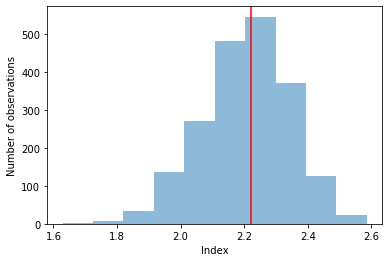

In [16]:
index = np.array([_["index"] for _ in results])
plt.hist(index, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["index"].value, color="red")
plt.xlabel("Index")
plt.ylabel("Number of observations")
print(f"index: {index.mean()} += {index.std()}")

amplitude: 1.4895129691116594e-12 += 7.240245988028585e-13


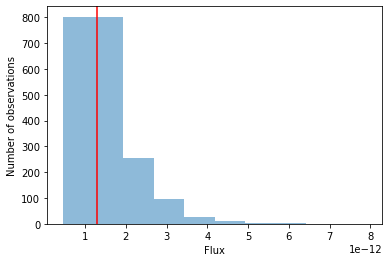

In [17]:
amplitude = np.array([_["amplitude"] for _ in results])
plt.hist(amplitude, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["amplitude"].value, color="red")
plt.xlabel("Flux")
plt.ylabel("Number of observations")
print(f"amplitude: {amplitude.mean()} += {amplitude.std()}")

lambda_: 5.114960224633545 += 0.9764884353844602


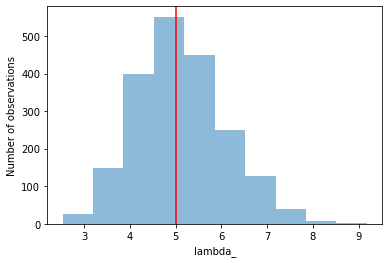

In [18]:
lambda_ = np.array([_["lambda_"] for _ in results])
plt.hist(lambda_, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["lambda_"].value, color="red")
plt.xlabel("lambda_")
plt.ylabel("Number of observations")
print(f"lambda_: {lambda_.mean()} += {lambda_.std()}")